# Project 4 Clustering & Topic Modeling Yelp Reviews of Restaurants in IL
## Modeling Part
## Katie Fan

Index
1. Load Data
2. Preprocess Data
 - 2.1 Clean Data
 - 2.2 CountVecterize
 - 2.3 TF-IDF Vectorize
3. Clustreing
 - 3.1 Dimensionality Reduction and Normalization
 - 3.2 Elbow Curve
 - 3.3 K Means Clustering
 - 3.4 TSNE Plotting
4. Topic Modeling
 - 4.1 Models with CountVecterized Data
      - 4.1.1 LSA
      - 4.1.2 NMF
      - 4.1.3 LDA
 - 4.2 Models with TF-IDF Vectorized Data
      - 4.2.1 LSA
      - 4.2.2 NMF
      - 4.2.3 LDA
 - 4.3 Choose the best model

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import PorterStemmer
from sklearn.feature_extraction import text 
#from nltk.tokenize import word_tokenize
from gensim import corpora, models, similarities, matutils
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
import collections
from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/katiefan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/katiefan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Load Data

In [11]:
# load pickled data
df = pd.read_pickle('/Users/katiefan/Documents/projects/project-4/prj4-df-clean')

In [12]:
# take a look at head rows of the dataset
df.head()

,_id,business_id,stars_x,text,name,city,stars_y,review_count,categories,is_open,review_length
332,5cdc66e40028847c6f0e7760,zswdqM8Av3KxVv9o7_6ORA,4.0,Everything was pretty good but the beef in the...,Rainbow Garden,Champaign,3.5,74,"Restaurants, Caterers, Chinese, Event Planning...",1,262
333,5cdc66e40028847c6f0ec475,zswdqM8Av3KxVv9o7_6ORA,4.0,i was in town visiting some friends and we had...,Rainbow Garden,Champaign,3.5,74,"Restaurants, Caterers, Chinese, Event Planning...",1,314
334,5cdc66e50028847c6f0f1ea6,zswdqM8Av3KxVv9o7_6ORA,3.0,Love their food and was a regular but I had to...,Rainbow Garden,Champaign,3.5,74,"Restaurants, Caterers, Chinese, Event Planning...",1,395
335,5cdc66e50028847c6f0f717a,zswdqM8Av3KxVv9o7_6ORA,5.0,We had originally planned on eating at Golden ...,Rainbow Garden,Champaign,3.5,74,"Restaurants, Caterers, Chinese, Event Planning...",1,786
336,5cdc66e60028847c6f0fa950,zswdqM8Av3KxVv9o7_6ORA,2.0,I would have ordered from this place again if ...,Rainbow Garden,Champaign,3.5,74,"Restaurants, Caterers, Chinese, Event Planning...",1,121


In [13]:
# get the shape of the dataset
df.shape

(21922, 11)

## 2. Preprocess Data

### 2.1 Clean Data

In [14]:
# define a customized drop list of words
drop_list = ['alway', 'aa', 'aaaaahhh', 'aah', 'ahh', 'ahhh', 'ahhhh', 'ahhhhh', 'ahhhhhh', 'ahhhhhhhh', 'ahhhhhhhhhhhh', 'aaa', 'aaah',  'aaahhhh', 'awu', 'aww', 'aaaaaaand', 'aaaaand', 'aaaannnd']

In [15]:
# create a function for preprocessing text reviews
def preprocess(raw_text):
    """return clean text data"""
    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)
    
    # remove '\n' from text
    letters_clean_text = letters_only_text.replace("\n", "")
    
    # convert to lower case and split 
    words = letters_clean_text.lower().split()
    
    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    meaningful_words = [w for w in words if w not in stopword_set]
    keep_words = [w for w in meaningful_words if w not in drop_list]
    
    # remove morphological affixes from words
    stemmed_words = [PorterStemmer().stem(w) for w in keep_words]
    
    # join the cleaned words in a list
    corpus = " ".join(stemmed_words)

    return corpus


In [17]:
# apply the function to reviews
corpus = df.text.apply(preprocess)
corpus[0:5]

332    everyth pretti good beef mongolian beef chewi ...
333    town visit friend take rainbow garden thing ce...
334    love food regular stop eat food soooooooo oili...
335    origin plan eat golden harbor even though exac...
336    would order place driver scam extra dollar loo...
Name: text, dtype: object

### 2.2 CountVectorization

In [18]:
# coutvectorize the cleaned text reviews
countvec = CountVectorizer( stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")
doc_word_cv = countvec.fit_transform(corpus)
doc_word_cv.shape

(21922, 18028)

In [20]:
# get doc word matrix
doc_word_matrix_cv = pd.DataFrame(doc_word_cv.toarray(), index=df.text, columns=countvec.get_feature_names())
doc_word_matrix_cv.head(1)

,aaaaaamaz,aaaammmaaaz,aaammmazinggggg,aah,aamsotto,aanag,aardvark,aaron,aarp,aaw,...,zucchini,zuchini,zuft,zuni,zupf,zuppa,zydeco,zyggyz,zyygyz,zza
text,,,,,,,,,,,,,,,,,,,,,
Everything was pretty good but the beef in the Mongolian beef was very chewy and had a weird texture. I know this is always a 50/50 chance when trying a new Chinese restaurant. The rest of the food was very good! Their noodles are really good and the fried rice.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.3 TF-IDF Vectorization

In [21]:
# TF-IDF vectorize the cleaned text reviews
tfidfvec = TfidfVectorizer(stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")
doc_word_tv = tfidfvec.fit_transform(corpus)
doc_word_tv.shape

(21922, 18028)

In [22]:
# get doc word matrix
doc_word_matrix_tv = pd.DataFrame(doc_word_tv.toarray(), index=df.text, columns=tfidfvec.get_feature_names())
doc_word_matrix_tv.head(1)

,aaaaaamaz,aaaammmaaaz,aaammmazinggggg,aah,aamsotto,aanag,aardvark,aaron,aarp,aaw,...,zucchini,zuchini,zuft,zuni,zupf,zuppa,zydeco,zyggyz,zyygyz,zza
text,,,,,,,,,,,,,,,,,,,,,
Everything was pretty good but the beef in the Mongolian beef was very chewy and had a weird texture. I know this is always a 50/50 chance when trying a new Chinese restaurant. The rest of the food was very good! Their noodles are really good and the fried rice.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Clustering

### 3.1 Dimensionality Reduction and Normalization

In [23]:
# create a pipeline with TruncatedSVD and normalization
svd = TruncatedSVD(50)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
doc_word_tv_tr = lsa.fit_transform(doc_word_tv) 

### 3.2 Elbow Curve

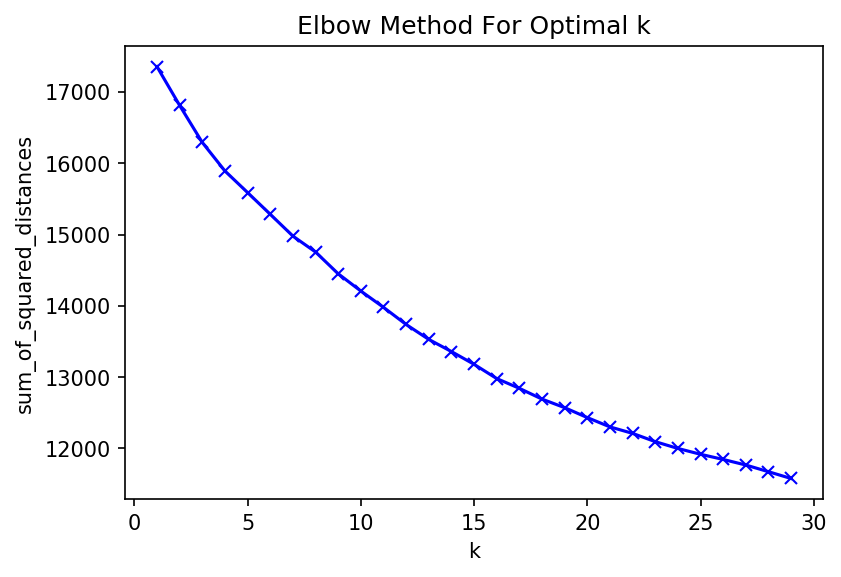

In [24]:
# plot elbow curve to find the optimal number of clusters
plt.figure(dpi=150)
sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(doc_word_tv_tr)
    sum_of_squared_distances.append(km.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### 3.3 K Means Clustering

In [25]:
# from elbow curve, it seems the optimal number of clusters is 20
# do k means clustering
num_clusters = 20
km = KMeans(init='k-means++', n_clusters=num_clusters, random_state=200)
km.fit(doc_word_tv_tr)
clusters = km.labels_.tolist()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
clusters_idx = km.fit_predict(doc_word_tv_tr)

In [27]:
# get number of reviews in each cluster
clustering = collections.defaultdict(list)
for idx, label in enumerate(km.labels_):
    clustering[label].append(idx)
for i in range(num_clusters):    
    print('number of reviews in cluster'+ str(i) +' : '+ str(len(clustering[i])))

number of reviews in cluster0 : 802
number of reviews in cluster1 : 1401
number of reviews in cluster2 : 994
number of reviews in cluster3 : 786
number of reviews in cluster4 : 1090
number of reviews in cluster5 : 2060
number of reviews in cluster6 : 822
number of reviews in cluster7 : 1592
number of reviews in cluster8 : 583
number of reviews in cluster9 : 1175
number of reviews in cluster10 : 756
number of reviews in cluster11 : 1382
number of reviews in cluster12 : 730
number of reviews in cluster13 : 2566
number of reviews in cluster14 : 552
number of reviews in cluster15 : 1074
number of reviews in cluster16 : 833
number of reviews in cluster17 : 832
number of reviews in cluster18 : 1132
number of reviews in cluster19 : 760


In [28]:
# try some cluster
c_1 = clustering[1][:10]
c_1

[10, 20, 28, 79, 112, 116, 133, 135, 157, 161]

In [31]:
# try some restaurants from cluster 1
for i in c_1:
    print(df.iloc[i]['name'])
    print(df.iloc[i].text)

Rainbow Garden
Superb. Great staff, great food, and large servings.
Rainbow Garden
Extremely fast delivery! Great crab rangoons.
Rainbow Garden
Pretty good food, great atmosphere when eating in. The chicken lo-mein is scary in that I know it's not great for me but, it tastes sooo good I can't stop eating it.
Cheese and Crackers
Wonderful place Awsome customer service and great selection allows me to feel as though I'm in a small little shop in Europe love it nothing but good from here
Cheese and Crackers
Freshest fish in town along with a great selection of cheeses, meats, pastas, sauces, chocolate crackers, olives and more. A very knowledgeable and helpful staff is a great plus!
Cheese and Crackers
Great selection of specialty cheeses & meats along with a lovely selection of chocolates. The owners are great - and the service is awesome! Really love all the food and staff!
Cheese and Crackers
Awesome place, we were on the mood for some cheese but didn't know what we got great service a

### 3.4 TSNE Plotting

In [33]:
# run TSNE on data
X = doc_word_tv_tr
model = TSNE(n_components=2, random_state=0,verbose=0)
low_data = model.fit_transform(X)

In [34]:
# get TSNE data
low_data_df = pd.DataFrame(low_data)
low_data_df.head()

,0,1
0,10.520892,47.587551
1,6.518598,-8.908472
2,14.490887,-13.389950
3,14.586189,46.530453
4,-9.920389,23.425304


In [35]:
# get label data
label = pd.DataFrame(clusters_idx)
label.head()

,0
0,19
1,13
2,5
3,19
4,2


In [36]:
# get dataset for TSNE plotting
df_subset = pd.concat([low_data_df, label], axis=1)
df_subset.columns = ['0', '1', 'cluster']
df_subset.head()

,0,1,cluster
0,10.520892,47.587551,19
1,6.518598,-8.908472,13
2,14.490887,-13.389950,5
3,14.586189,46.530453,19
4,-9.920389,23.425304,2


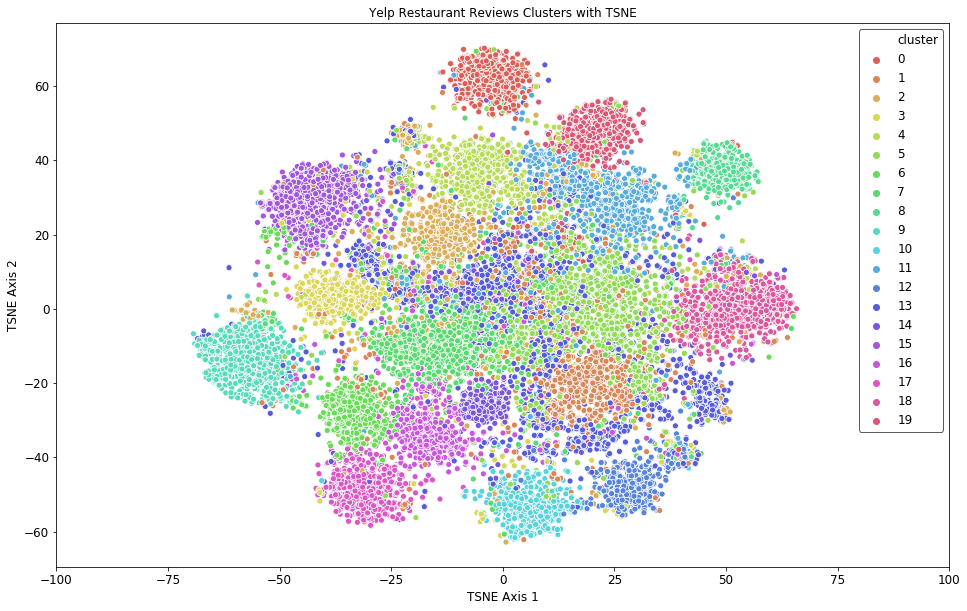

In [39]:
# plot TSNE
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="0", y="1",
    hue="cluster",
    palette=sns.color_palette("hls", 20),
    #palette=['#1b9e77', '#7570b3', '#e7298a', '#cea262', '#ff6800', '#a6bdd7', '#c10020', '#817066', '#007d34', '#ffb300', '#803e75', '#f6768e', '#00538a', '#ff7a5c', '#53377a', '#ff8e00', '#b32851', '#f4c800', '#7f180d', '#d95f02'],
    data=df_subset,
    legend="full",
    alpha=1)
plt.legend(fontsize=12, loc='upper right', frameon=True, facecolor='#FFFFFF', edgecolor='#333333')
plt.xlim(-100,100);
plt.title("Yelp Restaurant Reviews Clusters with TSNE", fontsize=12)
plt.ylabel("TSNE Axis 2", fontsize=12)
plt.xlabel("TSNE Axis 1", fontsize=12);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('km_clusters_15.png', dpi=200);

## 4. Topic Modelling

In [43]:
# create a function for displaying top words in a topic
def display_topics(model, feature_names, no_top_words, topic_names=None):
    """Returns top words in topic."""
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

## 4.1 Models with CountVecterized Data

### 4.1.1 LSA

In [44]:
# run lsa model on countvectorized data
lsa_cv = TruncatedSVD(5)
doc_topic_lsa_cv = lsa_cv.fit_transform(doc_word_cv)
lsa_cv.explained_variance_ratio_

array([0.04841618, 0.01732419, 0.0166043 , 0.01329   , 0.01176081])

In [45]:
# get topic word matrix
topic_word_lsa_cv = pd.DataFrame(lsa_cv.components_.round(3),
                                 index = ["component_1","component_2", 'component_3', 'comonent_4', 'comonent_5'],
                                 columns = countvec.get_feature_names())
topic_word_lsa_cv

,aaaaaamaz,aaaammmaaaz,aaammmazinggggg,aah,aamsotto,aanag,aardvark,aaron,aarp,aaw,...,zucchini,zuchini,zuft,zuni,zupf,zuppa,zydeco,zyggyz,zyygyz,zza
component_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_2,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.000,-0.0,-0.0,...,-0.000,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0
component_3,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.000,0.0,0.0,...,0.000,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
comonent_4,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.000,-0.0,0.0,...,-0.000,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
comonent_5,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.001,-0.0,-0.0,...,-0.001,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0


In [49]:
# get top 5 words in each topic
print('Topics by CountVectorize & LSA:')
display_topics(lsa_cv, countvec.get_feature_names(), 5)

Topics by CountVectorize & LSA:

Topic  0
food, good, place, order, like

Topic  1
order, food, minut, wait, time

Topic  2
pizza, order, like, sauc, chees

Topic  3
pizza, place, great, time, wait

Topic  4
good, pizza, food, servic, time


In [48]:
# get doc topic matrix
doc_topics_lsa_cv = pd.DataFrame(doc_topic_lsa_cv.round(3),
                         index = df.text,
                         columns = ["component_1","component_2", 'component_3', 'comonent_4', 'comonent_5'])
doc_topics_lsa_cv.head()

,component_1,component_2,component_3,comonent_4,comonent_5
text,,,,,
Everything was pretty good but the beef in the Mongolian beef was very chewy and had a weird texture. I know this is always a 50/50 chance when trying a new Chinese restaurant. The rest of the food was very good! Their noodles are really good and the fried rice.,2.162,-1.421,-0.417,-1.210,1.695
i was in town visiting some friends and we had some take out from rainbow garden.\n\nthe only thing that i am certain of is that this place has the most def tastiest (if that's a word) crab rangoon. it's crispy and chewy and filled with yummy cheese.\n\nnext time i'm in town i will be sure to stop in and eat eat eat!,1.135,-0.182,0.240,0.662,-0.523
"Love their food and was a regular but I had to stop eating there because the food is soooooooo oily. I asked them several time to cook my food with the least amount of oil but that didn't work! If you don't mind the oil dripping from your food, then this is a great place, nice relaxed atmosphere, owner operated and very nice. They also deliver with min order of 10 or 20 depending on location.",2.912,1.086,-2.781,0.612,0.095
"We had originally planned on eating at Golden Harbor even though we weren't exactly satisfied with our food our first trip there. They were packed, and lucky for me, my husband agreed to try this place rather than a Chinese Buffet (blech!). We soooo over ordered. We started with Sechuan Wontons which were tasty and inexpensive. I ordered Basil Chicken, labeled spicy, and loved it although there was no heat. My husband ordered General Shrimp which was the best General anything Chinese I've had. He also had Beef Lo Mein that was pretty tasty. The prices seem high, but when you see the portions, they are quite fair. We have at least two meals each to take home with us. I'm very pleased with the friendly service and the fact that $42.66 bought us 6 meals total. So good!",3.183,0.598,-0.094,-1.067,-0.445
I would have ordered from this place again if the driver hadn't of scammed me for an extra dollar. Look at your receipt!,0.624,0.199,0.210,0.224,-0.508


### 4.1.2 NMF

In [50]:
# run NMF model on coutvectorized data
nmf_cv = NMF(5)
doc_topic_nmf_cv = nmf_cv.fit_transform(doc_word_cv)

In [51]:
# get topic word matrix
topic_word_nmf_cv = pd.DataFrame(nmf_cv.components_.round(3),
                                 index = ["component_1","component_2", "component_3", "component_4", "component_5"],
                                 columns = countvec.get_feature_names())
topic_word_nmf_cv

,aaaaaamaz,aaaammmaaaz,aaammmazinggggg,aah,aamsotto,aanag,aardvark,aaron,aarp,aaw,...,zucchini,zuchini,zuft,zuni,zupf,zuppa,zydeco,zyggyz,zyygyz,zza
component_1,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.002,0.000,0.001,...,0.010,0.0,0.004,0.000,0.001,0.000,0.000,0.0,0.000,0.000
component_2,0.0,0.0,0.0,0.001,0.000,0.001,0.0,0.005,0.000,0.000,...,0.004,0.0,0.000,0.000,0.004,0.001,0.000,0.0,0.000,0.000
component_3,0.0,0.0,0.0,0.000,0.001,0.000,0.0,0.000,0.000,0.000,...,0.001,0.0,0.000,0.002,0.000,0.000,0.000,0.0,0.001,0.001
component_4,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,...,0.000,0.0,0.000,0.000,0.001,0.000,0.000,0.0,0.000,0.002
component_5,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.001,0.000,...,0.011,0.0,0.000,0.000,0.001,0.000,0.002,0.0,0.000,0.000


In [52]:
# get top 5 words in each topic
print('Topics by CountVectorize & NMF:')
display_topics(nmf_cv, countvec.get_feature_names(), 5)

Topics by CountVectorize & NMF:

Topic  0
place, great, love, alway, time

Topic  1
order, time, wait, tabl, ask

Topic  2
food, restaur, servic, great, chines

Topic  3
pizza, crust, chees, papa, chicago

Topic  4
good, like, realli, sauc, fri


In [53]:
# get doc topics matrix
doc_topics_nmf_cv = pd.DataFrame(doc_topic_nmf_cv.round(3),
                    index = df.text,
                    columns = ["component_1","component_2", "component_3", "component_4", "component_5"])
doc_topics_nmf_cv.head()

,component_1,component_2,component_3,component_4,component_5
text,,,,,
Everything was pretty good but the beef in the Mongolian beef was very chewy and had a weird texture. I know this is always a 50/50 chance when trying a new Chinese restaurant. The rest of the food was very good! Their noodles are really good and the fried rice.,0.000,0.000,0.067,0.000,0.172
i was in town visiting some friends and we had some take out from rainbow garden.\n\nthe only thing that i am certain of is that this place has the most def tastiest (if that's a word) crab rangoon. it's crispy and chewy and filled with yummy cheese.\n\nnext time i'm in town i will be sure to stop in and eat eat eat!,0.077,0.031,0.002,0.017,0.005
"Love their food and was a regular but I had to stop eating there because the food is soooooooo oily. I asked them several time to cook my food with the least amount of oil but that didn't work! If you don't mind the oil dripping from your food, then this is a great place, nice relaxed atmosphere, owner operated and very nice. They also deliver with min order of 10 or 20 depending on location.",0.063,0.057,0.261,0.000,0.000
"We had originally planned on eating at Golden Harbor even though we weren't exactly satisfied with our food our first trip there. They were packed, and lucky for me, my husband agreed to try this place rather than a Chinese Buffet (blech!). We soooo over ordered. We started with Sechuan Wontons which were tasty and inexpensive. I ordered Basil Chicken, labeled spicy, and loved it although there was no heat. My husband ordered General Shrimp which was the best General anything Chinese I've had. He also had Beef Lo Mein that was pretty tasty. The prices seem high, but when you see the portions, they are quite fair. We have at least two meals each to take home with us. I'm very pleased with the friendly service and the fact that $42.66 bought us 6 meals total. So good!",0.046,0.139,0.088,0.000,0.072
I would have ordered from this place again if the driver hadn't of scammed me for an extra dollar. Look at your receipt!,0.048,0.039,0.000,0.000,0.000


### 4.1.3 LDA

In [54]:
# transpose countvectorized data
doc_word_cv_t = doc_word_cv.transpose()

In [55]:
corpus_lda_cv = matutils.Sparse2Corpus(doc_word_cv_t)

In [56]:
id2word_lda_cv = dict((v, k) for k, v in countvec.vocabulary_.items())
len(id2word_lda_cv)

18028

In [59]:
# create lda model 
lda_cv = models.LdaModel(corpus=corpus_lda_cv, num_topics=5, id2word=id2word_lda_cv, passes=5)
lda_cv.print_topics()

[(0,
  '0.018*"good" + 0.016*"chicken" + 0.016*"sauc" + 0.014*"food" + 0.013*"fri" + 0.013*"place" + 0.010*"meat" + 0.010*"tri" + 0.010*"like" + 0.009*"sandwich"'),
 (1,
  '0.026*"place" + 0.020*"pizza" + 0.019*"great" + 0.019*"good" + 0.017*"food" + 0.011*"alway" + 0.009*"like" + 0.008*"love" + 0.008*"servic" + 0.008*"time"'),
 (2,
  '0.025*"order" + 0.020*"food" + 0.017*"time" + 0.014*"wait" + 0.011*"servic" + 0.011*"minut" + 0.010*"ask" + 0.009*"tabl" + 0.008*"like" + 0.008*"place"'),
 (3,
  '0.025*"food" + 0.019*"good" + 0.018*"place" + 0.014*"dish" + 0.012*"restaur" + 0.012*"sushi" + 0.011*"like" + 0.010*"thai" + 0.009*"roll" + 0.009*"order"'),
 (4,
  '0.014*"salad" + 0.011*"good" + 0.011*"beer" + 0.010*"great" + 0.009*"chees" + 0.009*"steak" + 0.008*"menu" + 0.008*"bar" + 0.008*"like" + 0.007*"order"')]

In [60]:
# Transform the docs from the word space to the topic space 
lda_corpus_cv = lda_cv[corpus_lda_cv]
lda_corpus_cv

In [61]:
# Store the documents' topic vectors in a list 
lda_docs_cv = [doc for doc in lda_corpus_cv]

## 4.2 TF-IDF Vectorize

### 4.2.1 LSA

In [64]:
# run LSA model on tf-idf vectrized data
lsa_tv = TruncatedSVD(5)
doc_topic_lsa_tv = lsa_tv.fit_transform(doc_word_tv)
lsa_tv.explained_variance_ratio_

array([0.00370788, 0.00666246, 0.00596607, 0.00552044, 0.00513141])

In [65]:
# get topic word matrix
topic_word_lsa_tv = pd.DataFrame(lsa_tv.components_.round(3),
                                 index = ["component_1","component_2", 'component_3', 'comonent_4', 'comonent_5'],
                                 columns = tfidfvec.get_feature_names())
topic_word_lsa_tv

,aaaaaamaz,aaaammmaaaz,aaammmazinggggg,aah,aamsotto,aanag,aardvark,aaron,aarp,aaw,...,zucchini,zuchini,zuft,zuni,zupf,zuppa,zydeco,zyggyz,zyygyz,zza
component_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.0,...,0.001,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
component_2,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.001,0.0,-0.0,...,-0.000,0.0,-0.0,-0.0,0.0,0.0,-0.000,-0.0,-0.0,0.0
component_3,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.000,-0.0,0.0,...,-0.001,-0.0,0.0,-0.0,-0.0,-0.0,-0.000,-0.0,-0.0,0.0
comonent_4,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.002,-0.0,-0.0,...,-0.001,-0.0,-0.0,0.0,-0.0,0.0,-0.001,-0.0,-0.0,0.0
comonent_5,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.001,0.0,0.0,...,0.001,0.0,0.0,-0.0,0.0,0.0,0.000,-0.0,-0.0,-0.0


In [66]:
# get top 5 words in each topics
print('Topics by TF-IDF Vectorize & LSA:')
display_topics(lsa_tv, tfidfvec.get_feature_names(), 5)

Topics by TF-IDF Vectorize & LSA:

Topic  0
food, good, place, great, order

Topic  1
pizza, crust, order, minut, wait

Topic  2
great, pizza, place, best, love

Topic  3
wait, servic, food, great, minut

Topic  4
burger, bbq, beer, sandwich, fri


In [67]:
# get doc topic matrix
doc_topics_lsa_tv = pd.DataFrame(doc_topic_lsa_tv.round(3),
                         index = df.text,
                         columns = ["component_1","component_2", 'component_3', 'comonent_4', 'comonent_5'])
doc_topics_lsa_tv.head()

,component_1,component_2,component_3,comonent_4,comonent_5
text,,,,,
Everything was pretty good but the beef in the Mongolian beef was very chewy and had a weird texture. I know this is always a 50/50 chance when trying a new Chinese restaurant. The rest of the food was very good! Their noodles are really good and the fried rice.,0.243,-0.098,-0.048,-0.162,-0.041
i was in town visiting some friends and we had some take out from rainbow garden.\n\nthe only thing that i am certain of is that this place has the most def tastiest (if that's a word) crab rangoon. it's crispy and chewy and filled with yummy cheese.\n\nnext time i'm in town i will be sure to stop in and eat eat eat!,0.140,0.012,-0.001,-0.033,0.002
"Love their food and was a regular but I had to stop eating there because the food is soooooooo oily. I asked them several time to cook my food with the least amount of oil but that didn't work! If you don't mind the oil dripping from your food, then this is a great place, nice relaxed atmosphere, owner operated and very nice. They also deliver with min order of 10 or 20 depending on location.",0.224,-0.034,0.042,0.101,-0.074
"We had originally planned on eating at Golden Harbor even though we weren't exactly satisfied with our food our first trip there. They were packed, and lucky for me, my husband agreed to try this place rather than a Chinese Buffet (blech!). We soooo over ordered. We started with Sechuan Wontons which were tasty and inexpensive. I ordered Basil Chicken, labeled spicy, and loved it although there was no heat. My husband ordered General Shrimp which was the best General anything Chinese I've had. He also had Beef Lo Mein that was pretty tasty. The prices seem high, but when you see the portions, they are quite fair. We have at least two meals each to take home with us. I'm very pleased with the friendly service and the fact that $42.66 bought us 6 meals total. So good!",0.225,-0.050,-0.067,-0.098,-0.081
I would have ordered from this place again if the driver hadn't of scammed me for an extra dollar. Look at your receipt!,0.077,0.021,-0.045,-0.001,-0.024


### 4.2.2 NMF

In [68]:
# run NMF model on tf-idf vectorized data
nmf_tv = NMF(5)
doc_topic_nmf_tv = nmf_tv.fit_transform(doc_word_tv)

In [69]:
# get topic word matrix
topic_word_nmf_tv = pd.DataFrame(nmf_tv.components_.round(3),
                                 index = ["component_1","component_2", "component_3", "component_4", "component_5"],
                                 columns = tfidfvec.get_feature_names())
topic_word_nmf_tv

,aaaaaamaz,aaaammmaaaz,aaammmazinggggg,aah,aamsotto,aanag,aardvark,aaron,aarp,aaw,...,zucchini,zuchini,zuft,zuni,zupf,zuppa,zydeco,zyggyz,zyygyz,zza
component_1,0.001,0.0,0.0,0.001,0.0,0.001,0.000,0.004,0.0,0.0,...,0.002,0.0,0.000,0.0,0.000,0.001,0.000,0.000,0.000,0.000
component_2,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.001,0.0,0.0,...,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.001
component_3,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.003,0.0,0.0,...,0.003,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000
component_4,0.000,0.0,0.0,0.000,0.0,0.000,0.001,0.000,0.0,0.0,...,0.003,0.0,0.000,0.0,0.000,0.000,0.001,0.001,0.001,0.000
component_5,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,...,0.005,0.0,0.001,0.0,0.001,0.000,0.001,0.000,0.000,0.000


In [70]:
# get top 5 words in each topic
print('Topics by TF-IDF Vectorize & NMF:')
display_topics(nmf_tv, tfidfvec.get_feature_names(), 5)

Topics by TF-IDF Vectorize & NMF:

Topic  0
order, wait, time, minut, tabl

Topic  1
pizza, crust, deep, papa, chicago

Topic  2
great, food, place, servic, alway

Topic  3
sushi, thai, chines, dish, roll

Topic  4
good, fri, sauc, chicken, burger


In [71]:
# get doc topic matrix
doc_topics_nmf_tv = pd.DataFrame(doc_topic_nmf_tv.round(3),
                    index = df.text,
                    columns = ["component_1","component_2", "component_3", "component_4", "component_5"])
doc_topics_nmf_tv.head()

,component_1,component_2,component_3,component_4,component_5
text,,,,,
Everything was pretty good but the beef in the Mongolian beef was very chewy and had a weird texture. I know this is always a 50/50 chance when trying a new Chinese restaurant. The rest of the food was very good! Their noodles are really good and the fried rice.,0.000,0.000,0.008,0.059,0.044
i was in town visiting some friends and we had some take out from rainbow garden.\n\nthe only thing that i am certain of is that this place has the most def tastiest (if that's a word) crab rangoon. it's crispy and chewy and filled with yummy cheese.\n\nnext time i'm in town i will be sure to stop in and eat eat eat!,0.011,0.007,0.010,0.014,0.015
"Love their food and was a regular but I had to stop eating there because the food is soooooooo oily. I asked them several time to cook my food with the least amount of oil but that didn't work! If you don't mind the oil dripping from your food, then this is a great place, nice relaxed atmosphere, owner operated and very nice. They also deliver with min order of 10 or 20 depending on location.",0.027,0.000,0.053,0.000,0.000
"We had originally planned on eating at Golden Harbor even though we weren't exactly satisfied with our food our first trip there. They were packed, and lucky for me, my husband agreed to try this place rather than a Chinese Buffet (blech!). We soooo over ordered. We started with Sechuan Wontons which were tasty and inexpensive. I ordered Basil Chicken, labeled spicy, and loved it although there was no heat. My husband ordered General Shrimp which was the best General anything Chinese I've had. He also had Beef Lo Mein that was pretty tasty. The prices seem high, but when you see the portions, they are quite fair. We have at least two meals each to take home with us. I'm very pleased with the friendly service and the fact that $42.66 bought us 6 meals total. So good!",0.014,0.000,0.010,0.053,0.019
I would have ordered from this place again if the driver hadn't of scammed me for an extra dollar. Look at your receipt!,0.016,0.001,0.002,0.009,0.002


### 4.2.3 LDA

In [72]:
# transpose tf-idf vectorized data
doc_word_tv_t = doc_word_tv.transpose()

In [73]:
corpus_lda_tv = matutils.Sparse2Corpus(doc_word_tv_t)

In [74]:
id2word_lda_tv = dict((v, k) for k, v in tfidfvec.vocabulary_.items())
len(id2word_lda_tv)

18028

In [75]:
# create lda model 
lda_tv = models.LdaModel(corpus=corpus_lda_tv, num_topics=5, id2word=id2word_lda_tv, passes=5)
lda_tv.print_topics()

[(0,
  '0.007*"gyro" + 0.005*"latt" + 0.004*"prici" + 0.004*"tower" + 0.004*"legend" + 0.004*"croissant" + 0.004*"espresso" + 0.004*"boba" + 0.003*"venu" + 0.003*"danc"'),
 (1,
  '0.004*"udon" + 0.004*"cuban" + 0.003*"watson" + 0.003*"bibimbap" + 0.003*"tostada" + 0.003*"huarach" + 0.003*"children" + 0.002*"garcia" + 0.002*"tight" + 0.002*"plant"'),
 (2,
  '0.011*"sakanaya" + 0.009*"japanes" + 0.005*"tempura" + 0.004*"overr" + 0.004*"teriyaki" + 0.003*"fuck" + 0.002*"lai" + 0.002*"supermarket" + 0.002*"tag" + 0.002*"tiramisu"'),
 (3,
  '0.007*"ribey" + 0.007*"butter" + 0.005*"peanut" + 0.005*"sashimi" + 0.005*"biscuit" + 0.003*"sticki" + 0.003*"hash" + 0.003*"cupcak" + 0.003*"esquir" + 0.003*"perkin"'),
 (4,
  '0.009*"food" + 0.007*"good" + 0.007*"place" + 0.006*"great" + 0.006*"order" + 0.005*"time" + 0.005*"servic" + 0.005*"like" + 0.004*"best" + 0.004*"restaur"')]

In [76]:
# transform the docs from the word space to the topic space
lda_corpus_tv = lda_cv[corpus_lda_tv]
lda_corpus_tv

In [77]:
# store the documents' topic vectors in a list 
lda_docs_tv = [doc for doc in lda_corpus_tv]

## 4.3 Choose the best model

**NMF model with TF-IDF Vectorized data gives the best result of topics.**

**Topic 0 seems related to time**

top 5 words: order, wait, time, minut, tabl

**Topic 1 seems related to pizza**

top 5 words: pizza, crust, deep, papa, chicago

**Topic 2 seems related to service**

top 5 words: great, food, place, servic, alway

**Topic 3 seems related to Asian food**

top 5 words: sushi, thai, chines, dish, roll

**Topic 4 seems related to fast food**

top 5 words: good, fri, sauc, chicken, burger